# Performing Type 0/Critical Resetting 

Created on Mon Feb 5 2018

@author: abel

This notebook demonstrates the first set of results for "critical resetting," that is, driving the circadian oscillator close to the singularity using only light.

In [1]:
# imports
from __future__ import division

# basic numerical packages
import numpy as np
import casadi as cs
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# locally created packages for limit cycle analysis and plotting utilities
from LocalImports import LimitCycle as lc
from LocalImports import PlotOptions as plo

# importing two models here:
#   1. kronauer model is the kronauer model with light input directly parameterized as part 
#      of the functions. this is useful for performing the actual simulation, but importantly
#      is does NOT constitute a limit cycle because process L is not inherently cyclical. 
#      the integration tools work well, though.
#   2. simplified kronauer model (imported as skm) is the kronauer model's limit cycle 
#      component assuming zero light inputs. this is useful for solving for limit cycle 
#      quantities (PRCs, ARCs) or for finding the phase of the kronauer model (i.e. 
#      finding its location on the process P limit cycle)
from LocalModels.kronauer_model import model, param, EqCount, y0in, null_I
import LocalModels.simplified_kronauer_model as skm

In [2]:
# set-up way to get the phase of a point using the simplified model

# initialize limit cycle oscillator object
skron = lc.Oscillator(skm.model(), skm.param, skm.y0in)

# turn off the biological contstraint. (process P is non-physiological. 
# normally I would constain all concentrations to be positive, but that
# is non-essential here.)
skron.intoptions['constraints']=None
skron.calc_y0()
skron.limit_cycle()
skron.find_prc()

In [3]:
# figure out phase at which the pulse occurs for the 24.6h case, since that
# one is the most effective
y0 = [ 0.99996874,  0.10023398, 0] # initial conditions
param[3]=24.6                      # tau parameter, set to 24.6 
kron = lc.Oscillator(model(null_I), param, y0) # kronaur model within the 
#                                              oscillator object allows simple 
#                                              integration routines
kron.intoptions['constraints'] = None # constraints off


# integrate to get the solution just before the pulse is applied
sol_pre = kron.int_odes(10.4) 
ts_pre = kron.ts
y0_pulse = sol_pre[-1]  # initial pulse condition

# once we have the oscillator state before the pulse, we should find what phase 
# the oscillator is at, to figure out where to start the pulse for the controlled case
pulse_phase = skron.phase_of_point(y0_pulse[:-1]) # should give ~2.66 rad
print "first pulse applied at a phase of "+str(pulse_phase)+ " radians"

first pulse applied at a phase of 2.661657096854635 radians


# SHOOTING BLIND

Before the control, though, let's try the three-pulse experiment NOT under control. So, get to 10.4h (2.5h before CBTmin), apply the pulse for 5h, apply no light for 19h, repeat for three pulses.


In [4]:
# untargeted stimulus function. try it out in the next cell after defining it.
def threecycle_stimulus(tau, pulse_dur=5, pulse_space=19):
    """
    Applies the 3-cycle stimulus protocol for a given tau

    Arguments
    ----------
    tau : float
        period of oscillation
    pulse_dur : float
        length of the 9500 lux light stimulus
    pulse_space : float
        length of dark/dim light following the pulse. should add to 24.
    """

    # pre-pulse: set up the model, integrate to 10.4 h where first pulse begins.
    y0 = [ 0.99996874,  0.10023398, 0]
    param[3]=tau
    kron = lc.Oscillator(model(null_I), param, y0)
    kron.intoptions['constraints']=None
    dsol_pre = kron.int_odes(10.4)
    dts_pre = kron.ts
    y0_pulse = dsol_pre[-1]

    dsol_pulses = [dsol_pre]
    dts_pulses = [dts_pre]
    for i in range(2):
        # during pulse
        kron = lc.Oscillator(model(I_pulse), param, y0_pulse)
        kron.intoptions['constraints']=None
        dsol_dur = kron.int_odes(pulse_dur)
        dts_dur = kron.ts

        # after pulse
        kron = lc.Oscillator(model(null_I), param, dsol_dur[-1])
        kron.intoptions['constraints']=None
        dsol_post = kron.int_odes(pulse_space)
        dts_post = kron.ts

        y0_pulse = dsol_post[-1]
        dts_pulses.append(dts_dur+dts_pulses[-1][-1])
        dts_pulses.append(dts_post+dts_pulses[-1][-1])
        dsol_pulses.append(dsol_dur)
        dsol_pulses.append(dsol_post)

    final_dist = np.sqrt(np.sum(dsol_dur[-1][:2]**2))
    dsol_pulses = np.vstack(dsol_pulses)
    dts_pulses = np.hstack(dts_pulses)
    
    # returnds time points, solution trajectories, and the distance to the 
    # fixed point (0,0) at the end of the last pulse
    return dts_pulses, dsol_pulses, final_dist

# pulse function formula
def I_pulse(t):
    """ returns just max lux """
    return 9500

In [5]:
# try playing around with different parts if you want
# 24.2 h period, standard 5h pulse/19h spacing. 
ts, sol, final_dist = threecycle_stimulus(24.) 

# distance in state space from crit pt
print "distance to critical pt (AU): "+str(final_dist)

distance to critical pt (AU): 0.4905458778990966


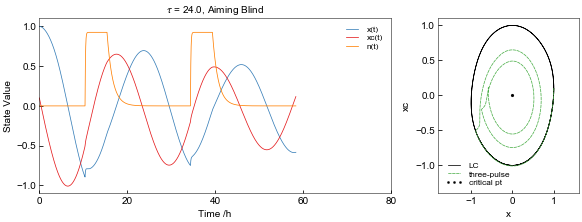

In [6]:
# make a plot to see how everything worked
plo.PlotOptions(ticks='in')
fig = plt.figure(figsize=(8,3))

gs = GridSpec(1,2, width_ratios=(2.5,1))

ax=plt.subplot(gs[0,0])
# dynamics plot
ax.plot(ts, sol[:,0], 'f', label ='x(t)')
ax.plot(ts, sol[:,1], 'h', label ='xc(t)')
ax.plot(ts, sol[:,2], 'l', label ='n(t)')
ax.set_xlim([0,80])
ax.set_ylim([-1.1,1.1])
ax.set_xlabel('Time /h')
ax.set_ylabel('State Value')
ax.legend()

bx=plt.subplot(gs[0,1])
# limit cycle plot
bx.plot(skron.lc(ts)[:,0], skron.lc(ts)[:,1], 'k', label ='LC')
bx.plot(sol[:,0], sol[:,1], 'i--', label ='three-pulse')
bx.plot(0,0,'ko',label='critical pt')
bx.set_xlabel('x')
bx.set_ylabel('xc')
bx.set_ylim([-1.4,1.1])
bx.set_xlim([-1.8,1.6])
bx.legend(loc=3)

ax.set_title(r'$\tau$ = '+str(param[3])+', Aiming Blind')
plt.tight_layout(**plo.layout_pad)
plt.show()

# saves the figure in LocalFigures for better resolution
fig.savefig('LocalFigures/blind_three_pulse'+str(param[3])+'.svg')

# CONTROL

So now that we see how it looks when shooting blind, what if instead we try to apply all pulses at the same
phase (+/- the 0.5h sampling rate)? We can do that by implementing a simple control algorithm.

We have:
 - the oscillator (kron, can be set up with other periods by changing param[3] (tau))
 - the phase at which the pulse should *begin*
 - a means for calculating oscillator phase (using the process P/simplified kronaur model limit cycle)
 
Then, these can all be connected for the three-pulse experiment to deliver it under control. The process would be:
 1. Start the oscillator at phase 0.
 2. Integrate forward a step in time (step duration, say, 0.5h. This is the maximal mistiming of the pulse).
 3. Calculate phase
 4. If phase < pulse phase: 
      - go to step 2.
 5.   Else if the oscillator has passed the pulse_phase:
      - start the pulse, apply the pulse for 5h.
      - since the pulse will not be needed again for at least 15h, just advance then 15h without the pulse. this is         solely to save time on phase calculations over that time, which can be slow.

Now, we will define a process to perform that control.


In [7]:
# targeted stimulus formula
def threecycle_targeted_stimulus(tau, phase_target, pulse_dur = 5):
    """
    Applies the 3-cycle stimulus protocol for a given tau

    Arguments
    ----------
    tau : float
        period of oscillation
    phase_target : float
        phase at which we want to apply the pulse
    pulse_dur : float
        duration of the 9500lux pulse
    """

    # set up parameters for first time
    y0 = [ 0.99996874,  0.10023398, 0]
    param[3]=tau

    dsol_total = [[y0]]
    dts_total = [[0]]
    for pulsecount in range(2):

        # set up oscillator
        kron = lc.Oscillator(model(null_I), param, y0)
        kron.intoptions['constraints']=None
        phase = skron.phase_of_point(y0[:-1])

        # move forward when it's before the pulse time, or after the pulse
        while np.logical_or(phase < phase_target,
                            phase > phase_target+3/tau*2*np.pi):
            # perform the integration
            dsol_pre = kron.int_odes(0.5, numsteps=100)
            dts_pre = kron.ts
            yend = dsol_pre[-1]
            phase = skron.phase_of_point(yend[:-1])
            kron.y0 = yend

            # append the integration
            dsol_total.append(dsol_pre)
            dts_total.append(dts_pre+dts_total[-1][-1])


        # when it's time, apply the pulse
        kron = lc.Oscillator(model(I_pulse), param, yend)
        kron.intoptions['constraints']=None
        dsol_dur = kron.int_odes(pulse_dur)
        dts_dur = kron.ts

        y0 = dsol_dur[-1]
        dts_total.append(dts_dur+dts_total[-1][-1])
        dsol_total.append(dsol_dur)

    # residual 15h period after pulse - no need to try to target here
    kron = lc.Oscillator(model(null_I), param, dsol_dur[-1])
    kron.intoptions['constraints']=None
    dsol_post = kron.int_odes(15)
    dts_post = kron.ts

    dts_total.append(dts_post+dts_total[-1][-1])
    dsol_total.append(dsol_post)

    final_dist = np.sqrt(np.sum(dsol_dur[-1][:2]**2))
    dsol_total = np.vstack(dsol_total)
    dts_total = np.hstack(dts_total)

    return dts_total, dsol_total, final_dist

In [10]:
# ok performing this: the c just means controlled
cts, csol, cfinal_dist = threecycle_targeted_stimulus(24.0, pulse_phase) 
# pulse_phase was calculated above

# patience... this takes longer because we need to iteratively 
# sense phase and then time the pulse. takes me about 60-120 s 
# to run on lab desktop
print "distance to critical pt (AU): "+str(cfinal_dist)
print "\nimprovement of "+str(100*np.round(1-cfinal_dist/final_dist),2)+"pct"

distance to critical pt (AU): 0.4043550531993103


TypeError: str() takes at most 1 argument (2 given)

In [ ]:
# make a plot to see how everything worked
plo.PlotOptions(ticks='in')
fig = plt.figure(figsize=(8,3))

gs = GridSpec(1,2, width_ratios=(2.5,1))

ax=plt.subplot(gs[0,0])
# dynamics plot
ax.plot(cts, csol[:,0], 'f', label ='x(t)')
ax.plot(cts, csol[:,1], 'h', label ='xc(t)')
ax.plot(cts, csol[:,2], 'l', label ='n(t)')
ax.set_xlabel('Time /h')
ax.set_ylabel('State Value')
ax.set_xlim([0,80])
ax.set_ylim([-1.1,1.1])
ax.legend()

bx=plt.subplot(gs[0,1])
# limit cycle plot
bx.plot(skron.lc(cts)[:,0], skron.lc(cts)[:,1], 'k', label ='LC')
bx.plot(csol[:,0], csol[:,1], 'i--', label ='three-pulse')
bx.plot(0,0,'ko',label='critical pt')
bx.set_xlabel('x')
bx.set_ylabel('xc')
bx.set_ylim([-1.4,1.1])
bx.set_xlim([-1.8,1.6])
bx.legend(loc=3)

ax.set_title(r'$\tau$ = '+str(param[3])+', Control Applied')
plt.tight_layout(**plo.layout_pad)
plt.show()

# saves the figure in LocalFigures for better resolution
fig.savefig('LocalFigures/controlled_three_pulse'+str(param[3])+'.svg')